# Imports and hyperparameters

In [ ]:
import copy
import wandb
import os

import lightning as l
import torch
import torchvision
import torchmetrics
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

from lightly.data import LightlyDataset
from lightly.loss.vicreg_loss import VICRegLoss
from lightly.models.modules.heads import VICRegProjectionHead
from lightly.transforms.vicreg_transform import VICRegTransform
from lightly.models.utils import (
    batch_shuffle,
    batch_unshuffle,
    deactivate_requires_grad,
    update_momentum,
)
from lightly.transforms import utils
from torch.optim import SGD, Adam

In [ ]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: illyan (nest-ai). Use `wandb login --relogin` to force relogin


True

In [ ]:
num_workers = os.cpu_count()
batch_size = 512
memory_bank_size = 4096
seed = 1
max_epochs = 100
data_dir = '../data/'
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [ ]:
path_to_train = data_dir + "100-bird-species/train/"
path_to_valid = data_dir + "100-bird-species/valid/"
path_to_test = data_dir + "100-bird-species/test/"

In [ ]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(path_to_train)
num_classes = len(dataset.classes)
input_size = 512
fc_net = nn.Linear(input_size, num_classes) # Simple FC classifier
lin1_size = 64
lin2_size = 256
lin3_size = 256
deep_net = nn.Sequential( # DNN classifier
    nn.Linear(input_size, lin1_size),
    nn.BatchNorm1d(lin1_size),
    nn.ReLU(),
    nn.Linear(lin1_size, lin2_size),
    nn.BatchNorm1d(lin2_size),
    nn.ReLU(),
    nn.Linear(lin2_size, lin3_size),
    nn.BatchNorm1d(lin3_size),
    nn.ReLU(),
    nn.Linear(lin3_size, num_classes),
)
classifier_net = deep_net # Choose which classifier to use, fc_net or deep_net
print(num_classes)

525


In [ ]:
l.seed_everything(seed)

Seed set to 1


1

# Datasets

In [ ]:
train_vicreg_transform = VICRegTransform(
    input_size=32,
    gaussian_blur=0.0,
)

train_classifier_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [ ]:
dataset_train_vicreg = LightlyDataset(input_dir=path_to_train, transform=train_vicreg_transform)

dataset_train_classifier = LightlyDataset(
    input_dir=path_to_train, transform=train_classifier_transforms
)

dataset_valid = LightlyDataset(input_dir=path_to_valid, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

In [ ]:
dataloader_train_vicreg = torch.utils.data.DataLoader(
    dataset_train_vicreg,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_train_classifier = torch.utils.data.DataLoader(
    dataset_train_classifier,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

# VICReg class 
SSL-method with pretrained resnet18 backbone

In [ ]:
class VICReg(l.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = VICRegProjectionHead(
            input_dim=512,
            hidden_dim=2048,
            output_dim=2048,
            num_layers=4,
        )
        self.criterion = VICRegLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1) = batch[0]
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("vicreg_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optim = Adam(self.parameters(), lr=0.06)
        return optim

# Classifier class
Defining one classification layer after the backbone

In [ ]:
class Classifier(l.LightningModule):
    def __init__(self, backbone, freeze, num_classes, net):
        super().__init__()
        self.backbone = backbone

        if freeze:
            # freeze the backbone
            deactivate_requires_grad(backbone)

        # create a linear layer for our downstream classification model
        self.net = net

        self.firstTime = True

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.validation_step_outputs = []

    def forward(self, x):
        y_hat = self.backbone(x).flatten(start_dim=1)
        y_hat = self.net(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        if self.firstTime:
            self.firstTime = False
            print(type(x))
            print(x)
            print(type(y))
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("classifier_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)

        _, predicted = torch.max(y_hat, 1)
        num = predicted.shape[0]
        correct = (predicted == y).float().sum()
        self.validation_step_outputs.append((num, correct))
        return num, correct

    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            total_num = 0
            total_correct = 0
            for num, correct in self.validation_step_outputs:
                total_num += num
                total_correct += correct
            acc = total_correct / total_num
            self.log("val_acc", acc, on_epoch=True, prog_bar=True)
            self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y)
        accuracy = self.accuracy(y_hat, y)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        return (y_hat, y)

    def configure_optimizers(self):
        optim = Adam(self.net.parameters(), lr=0.002884)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

# Training

You can load the trained models after each training cell by specifying the appropriate path and commenting out the required lines

## VICReg training

In [32]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="VICReg", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='vicreg_loss',
    mode='min',
    dirpath = './models/',
    filename = 'best_model_vicreg',
)

ssl_model = VICReg()
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)
trainer.fit(model=ssl_model, train_dataloaders=dataloader_train_vicreg)

wandb.finish()

C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\loggers\wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head

epoch,▁▁▁▁▁
test_acc,▁▁▆█▁
test_loss,█▃▁▁▄
trainer/global_step,▁▁▁▁▁
epoch,0
test_acc,0.008
test_loss,6.08163
trainer/global_step,0


In [ ]:
# Before running change ckpt_path to the correct one
# ckpt_path = "models/best_model_vicreg.ckpt"

# ssl_model = VICReg()
# ssl_model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict'])

## Classifier training

In [ ]:
def train_classifier(wandb_name, filename, backbone, freeze, max_eps):
    wandb_logger = l.pytorch.loggers.WandbLogger(
        name=wandb_name, project="Self-supervised learning in-the-wild"
    )
    callback = l.pytorch.callbacks.ModelCheckpoint(
        monitor='val_acc',
        mode='max',
        dirpath = './models/',
        filename = filename,
    )

    classifier = Classifier(backbone, freeze, num_classes, classifier_net)
    trainer = l.pytorch.Trainer(
        max_epochs=max_eps, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]

    )
    trainer.fit(classifier, dataloader_train_classifier, dataloader_valid)

    wandb.finish()

    return classifier

### With ssl pretrained backbone and frozen weights

In [ ]:
model_ssl_frozen = train_classifier("Classifier ssl frozen backbone",
                                    'best_model_with_ssl_frozen',
                                    ssl_model.backbone, True, max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | Sequential         | 11.2 M
1 | fc        | Sequential         | 251 K 
2 | criterion | CrossEntropyLoss   | 0     
3 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
251 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.711    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/165 [00:00<?, ?it/s]                           <class 'torch.Tensor'>
tensor([[[[-0.5082, -0.5082, -0.6281,  ...,  0.7591,  0.8104,  0.8104],
          [-0.5253, -0.4911, -0.5253,  ...,  0.6049,  0.6221,  0.7419],
          [-0.4911, -0.4739, -0.4911,  ...,  0.5878,  0.5707,  0.6906],
          ...,
          [-0.1657, -0.1143,  0.0056,  ..., -0.5424, -0.5082, -0.5253],
          [-0.2171, -0.1486,  0.0227,  ..., -0.5938, -0.5938, -0.5767],
          [-0.2513, -0.1828, -0.0116,  ..., -0.6281, -0.7137, -0.7993]],

         [[-0.3901, -0.4076, -0.5301,  ...,  0.9405,  0.9930,  0.9930],
          [-0.3901, -0.3901, -0.4251,  ...,  0.7829,  0.8004,  0.9230],
          [-0.3901, -0.3725, -0.3901,  ...,  0.7479,  0.7304,  0.8704],
          ...,
          [ 0.6429,  0.6954,  0.8179,  ...,  0.0476,  0.0476, -0.0049],
          [ 0.6779,  0.7129,  0.8880,  ...,  0.0651,  0.0301,  0.0126],
          [ 0.6779,  0.7129,  0.8880,  ...,  0.0126, -0.0749, -0.1975]],

    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 165/165 [00:21<00:00,  7.86it/s, v_num=depp, val_acc=0.0114]


classifier_loss,█▇▇▆▇▆▆▆▇▅▆▅▄▆▄▆▅▄▄▄▅▄▄▄▃▃▄▃▄▃▄▃▅▁▅▄▄▃▄▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▂▂▃▄▅▂▅▃▄▅▄▅▆▂▄▆▄▄▄▇▆▅▅▇▄▆▅▅▄▄▄▅▅▆▆█▆▆▇
classifier_loss,5.90386
epoch,99
trainer/global_step,16499
val_acc,0.01143


In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_ssl_frozen.ckpt"

ssl_model = VICReg()
model_ssl_frozen = Classifier(ssl_model.backbone, True, num_classes, classifier_net)
model_ssl_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

### With ssl pretrained backbone and NOT frozen weights

In [ ]:
model_ssl_not_frozen = train_classifier("Classifier ssl not frozen backbone",
                                        'best_model_with_ssl_not_frozen',
                                        ssl_model.backbone, False, max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | Sequential         | 11.2 M
1 | fc        | Sequential         | 251 K 
2 | criterion | CrossEntropyLoss   | 0     
3 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
251 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.711    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/165 [00:00<?, ?it/s]                           <class 'torch.Tensor'>
tensor([[[[-1.6042, -1.5357, -1.1418,  ..., -1.0733, -1.1418, -1.0904],
          [-1.5357, -1.4843, -1.0904,  ..., -1.0390, -1.1932, -1.2274],
          [-1.6042, -1.4672, -1.0390,  ..., -1.1760, -1.2959, -1.3130],
          ...,
          [ 0.1939,  0.3309,  0.5022,  ..., -1.5014, -1.5528, -1.5699],
          [ 0.1083,  0.1939,  0.2967,  ..., -1.6042, -1.6042, -1.5699],
          [-0.0972, -0.0287,  0.0398,  ..., -1.6898, -1.6555, -1.6213]],

         [[-1.5980, -1.5280, -1.1253,  ..., -1.1779, -1.2479, -1.1954],
          [-1.5280, -1.4755, -1.0728,  ..., -1.1429, -1.3004, -1.3354],
          [-1.5980, -1.4580, -1.0203,  ..., -1.2479, -1.3704, -1.3880],
          ...,
          [ 1.1856,  1.2731,  1.3431,  ..., -1.4930, -1.5455, -1.5630],
          [ 1.1856,  1.2206,  1.2206,  ..., -1.5630, -1.5630, -1.5280],
          [ 1.0455,  1.0455,  1.0455,  ..., -1.6506, -1.6155, -1.5805]],

    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 165/165 [00:20<00:00,  8.06it/s, v_num=v0ou, val_acc=0.0122]


classifier_loss,██▆▄▅▅▄▅▅▅▄▆▆▅▆▅▅▅▄▄▃▂▃▅▅▃▄▄▃▄▄▂▃▁▃▃▃▃▄▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▄▃▁▅▃▂▄▃▄▃▄▆▄▃▅▅▄▇▃▃▆▆▅▃▆▆▅▆▆▅▄▄▇█▇▇▇▇
classifier_loss,5.90266
epoch,99
trainer/global_step,16499
val_acc,0.01219


In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_ssl_not_frozen.ckpt"

ssl_model = VICReg()
model_ssl_not_frozen = Classifier(ssl_model.backbone, False, num_classes, classifier_net)
model_ssl_not_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

### Without SSL, but pretrained backbone with frozen weights

In [ ]:
# Defining the pretrained backbone
# Running this cell is also required for loading from checkpoint

resnet_pt = torchvision.models.resnet18(pretrained=True)
backbone_pt = nn.Sequential(*list(resnet_pt.children())[:-1])

In [ ]:
model_pretrained_frozen = train_classifier("Classifier pretrained and frozen backbone",
                                           'best_model_with_pretrained_frozen',
                                           backbone_pt, True, max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | Sequential         | 11.2 M
1 | fc        | Sequential         | 251 K 
2 | criterion | CrossEntropyLoss   | 0     
3 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
251 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.711    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/165 [00:00<?, ?it/s]                            <class 'torch.Tensor'>
tensor([[[[ 1.1015,  1.0673,  0.9817,  ...,  0.8618,  0.8789,  0.8961],
          [ 1.0502,  1.0331,  0.9988,  ...,  0.6392,  0.6906,  0.7591],
          [ 0.8447,  0.8618,  0.8447,  ...,  0.4508,  0.5022,  0.5878],
          ...,
          [ 0.6563, -0.0972, -1.2788,  ..., -1.5699, -1.3644, -1.1247],
          [ 0.7591,  0.9817,  0.8961,  ..., -1.4158, -1.4672, -1.4843],
          [ 0.7248,  0.8447,  0.9988,  ..., -1.3815, -1.4158, -1.6555]],

         [[ 1.4307,  1.3957,  1.2906,  ...,  1.2906,  1.3081,  1.3256],
          [ 1.3606,  1.3431,  1.2731,  ...,  1.0280,  1.0980,  1.1681],
          [ 1.1506,  1.1331,  1.1155,  ...,  0.8354,  0.9055,  0.9930],
          ...,
          [ 0.8880,  0.1176, -1.1078,  ..., -1.3004, -1.1253, -0.8627],
          [ 0.9755,  1.2206,  1.1331,  ..., -1.1779, -1.2479, -1.2479],
          [ 0.9405,  1.0630,  1.2031,  ..., -1.1429, -1.1954, -1.4230]],

   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 165/165 [00:20<00:00,  8.21it/s, v_num=anot, val_acc=0.024]


classifier_loss,█▆▅▅▅▄▄▄▄▄▄▄▄▅▄▅▂▄▂▄▄▄▄▃▄▂▂▂▃▁▂▂▃▂▃▃▂▁▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▇▅▆▄▅█▄▄▆▆▅▇▅▅▅▅▆▅▆▅▆▅▆▆▇▇█▆█▆▆▆▆▅▆▆▆▇▅
classifier_loss,5.20814
epoch,99
trainer/global_step,16499
val_acc,0.024


In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_pt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_pretrained_frozen.ckpt"

model_pretrained_frozen = Classifier(backbone_pt, False, num_classes, classifier_net)
model_pretrained_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### Without SSL, but pretrained backbone with NOT frozen weights

In [ ]:
model_pretrained_not_frozen = train_classifier("Classifier pretrained and not frozen backbone",
                                               'best_model_with_pretrained_not_frozen',
                                               backbone_pt, False, max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | Sequential         | 11.2 M
1 | fc        | Sequential         | 251 K 
2 | criterion | CrossEntropyLoss   | 0     
3 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
251 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.711    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/165 [00:00<?, ?it/s]                            <class 'torch.Tensor'>
tensor([[[[ 1.5125,  1.5982,  1.6667,  ...,  0.5707,  0.4508,  0.4851],
          [ 1.4954,  1.4954,  1.4440,  ...,  0.7077,  0.6734,  0.6392],
          [ 1.3070,  1.3242,  1.3070,  ...,  0.8618,  0.8618,  0.7933],
          ...,
          [ 0.8789,  0.9646,  0.9303,  ...,  1.0844,  1.1015,  1.1015],
          [ 0.9988,  0.9303,  0.8961,  ...,  1.1015,  1.0844,  1.0844],
          [ 0.8447,  0.8447,  0.8789,  ...,  1.1015,  1.1015,  1.0844]],

         [[ 1.1331,  1.1681,  1.2381,  ...,  0.1702,  0.0126,  0.0126],
          [ 1.0630,  1.0280,  0.9755,  ...,  0.4328,  0.3452,  0.2752],
          [ 0.8880,  0.8704,  0.8354,  ...,  0.6429,  0.6078,  0.5203],
          ...,
          [ 0.4328,  0.5553,  0.5553,  ...,  0.9055,  0.8704,  0.8704],
          [ 0.5903,  0.5203,  0.5203,  ...,  0.8704,  0.8529,  0.8704],
          [ 0.4328,  0.4328,  0.5028,  ...,  0.8529,  0.8529,  0.8529]],

   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 165/165 [00:19<00:00,  8.29it/s, v_num=c725, val_acc=0.024]


classifier_loss,█▆▅▄▅▆▆▄▄▄▄▄▃▄▄▃▄▃▂▄▃▄▃▄▃▁▄▃▂▃▂▂▃▃▂▃▃▁▄▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃█▄▇▅▆██▇▅▅▄▆▄▆▅▆▆▅▄▅▄▇▇█▆▅█▇▆█▆▆▅▅▆▆▆▆
classifier_loss,5.17322
epoch,99
trainer/global_step,16499
val_acc,0.024


In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 4 up that defines the backbone_pt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_pretrained_not_frozen.ckpt"

model_pretrained_not_frozen = Classifier(backbone_pt, False, num_classes, classifier_net)
model_pretrained_not_frozen.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

### With untrained backbone

In [ ]:
# Defining the untrained backbone
# Running this cell is also required for loading from checkpoint

resnet_npt = torchvision.models.resnet18(pretrained=False)
backbone_npt = nn.Sequential(*list(resnet_npt.children())[:-1])

C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_untrained = train_classifier("Classifier untrained backbone",
                                   'best_model_with_untrained',
                                   backbone_npt, False, max_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | backbone  | Sequential         | 11.2 M
1 | fc        | Sequential         | 251 K 
2 | criterion | CrossEntropyLoss   | 0     
3 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.711    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/165 [00:00<?, ?it/s]                            <class 'torch.Tensor'>
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [ 1.1700,  1.1529,  1.1358,  ...,  0.9988,  0.9817,  0.9817],
          [ 1.1015,  1.0844,  1.0673,  ...,  1.0159,  0.9988,  0.9817],
          ...,
          [ 0.5364,  0.5536,  0.5536,  ..., -0.0116, -0.0287, -0.0287],
          [ 0.5878,  0.5707,  0.5536,  ..., -0.1314, -0.1828, -0.1486],
          [ 0.3823,  0.2967,  0.2111,  ..., -0.2856, -0.3541, -0.3541]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.4657,  1.4482,  1.4307,  ...,  1.3606,  1.3431,  1.3431],
          [ 1.3957,  1.3782,  1.3606,  ...,  1.3782,  1.3606,  1.3431],
          ...,
          [ 0.0651,  0.0826,  0.1001,  ..., -0.3550, -0.3725, -0.3725],
          [ 0.1176,  0.1001,  0.1001,  ..., -0.4426, -0.4426, -0.4601],
          [-0.1099, -0.1975, -0.2500,  ..., -0.5651, -0.6001, -0.6176]],

   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 165/165 [00:22<00:00,  7.28it/s, v_num=irdb, val_acc=0.00838]


classifier_loss,█▆▅▅▅▅▄▃▄▂▃▂▄▁▃▂▅▆▂▂▁▂▅▂▂▂▃▄▂▂▁▃▃▁▃▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▄▃▇█▃▅▇▆▄▅▃▅▃▄█▅▆▃▁▄▂▄▅▃▄▁▅▃▄▂▄▄▅▄▅▅▄▅▇▄
classifier_loss,5.77801
epoch,99
trainer/global_step,16499
val_acc,0.00838


In [ ]:
# Before running, change ckpt_with_classifier_path to the correct one,
# make sure you ran the cell 2 up that defines the backbone_npt
# and comment out the lines below.

ckpt_with_classifier_path = "models/best_model_with_untrained.ckpt"

model_untrained = Classifier(backbone_npt, False, num_classes, classifier_net)
model_untrained.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

<All keys matched successfully>

# Evaluation

## Accuracy on test dataset

In [ ]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="Classifier", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='val_acc',
    mode='max'
)
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)

models = [model_ssl_frozen, model_ssl_not_frozen, model_pretrained_frozen, model_pretrained_not_frozen, model_untrained]
titles = ["SSL and frozen backbone",
         "SSL and not frozen backbone",
         "Pretrained and frozen backbone",
         "Pretrained and not frozen backbone",
         "With untrained backbone"]

accuracies = []
losses = []
for model in models:
    model.eval()
    test = trainer.test(model, dataloader_test)
    accuracies.append(test[0]["test_acc"])
    losses.append(test[0]["test_loss"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 12.94it/s]


C:\Users\HLCaptain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 65. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.00685714278370142    │
│         test_loss         │     6.748806476593018     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 15.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.008380952291190624    │
│         test_loss         │     6.030611038208008     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 21.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.02628571353852749    │
│         test_loss         │     5.675470352172852     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 13.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.03161904588341713    │
│         test_loss         │     5.663997173309326     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 21.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.007999999448657036    │
│         test_loss         │     6.081631660461426     │
└───────────────────────────┴───────────────────────────┘

C:\Users\HLCaptain\AppData\Local\Temp\ipykernel_29116\3470356060.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(titles, rotation=45, ha='right')
C:\Users\HLCaptain\AppData\Local\Temp\ipykernel_29116\3470356060.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(titles, rotation=45, ha='right')


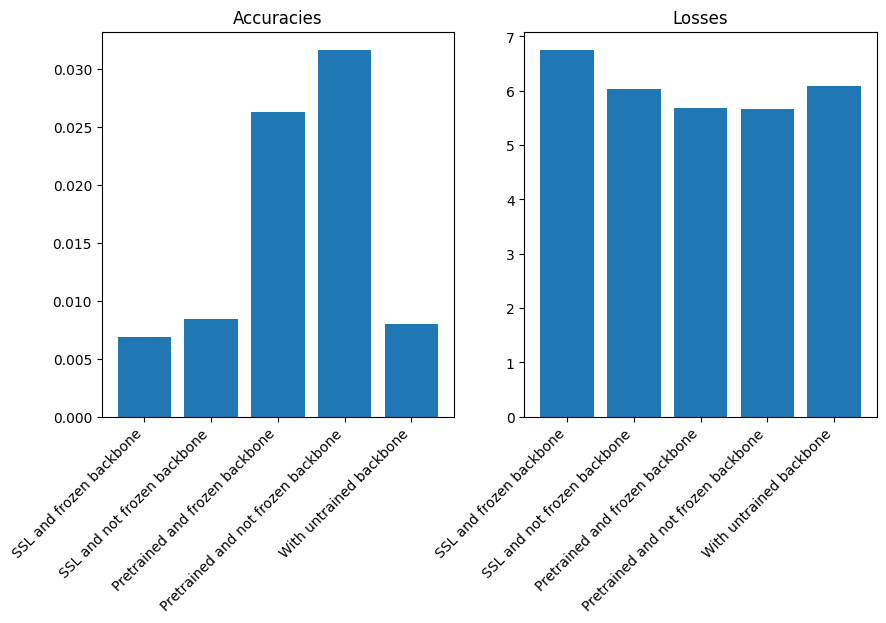

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(titles, accuracies)
ax1.set_title('Accuracies')
ax1.set_xticklabels(titles, rotation=45, ha='right')
ax2.bar(titles, losses)
ax2.set_title('Losses')
ax2.set_xticklabels(titles, rotation=45, ha='right')

plt.show()

## Confusion matrix

In [ ]:
def evaluate_model(model, dataloader, num_classes):
    confusion_matrix_metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=num_classes)
    model.eval()
    with torch.no_grad():
        for y_hat, y in trainer.predict(model, dataloader):
            confusion_matrix_metric(y_hat.softmax(dim=-1), y)
    confusion_matrix = confusion_matrix_metric.compute()
    return confusion_matrix

confusion_matrices = []
for model in models:
    confusion_matrices.append(evaluate_model(model, dataloader_test, num_classes))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 13.88it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 16.81it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 15.89it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 16.80it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 23.07it/s] 


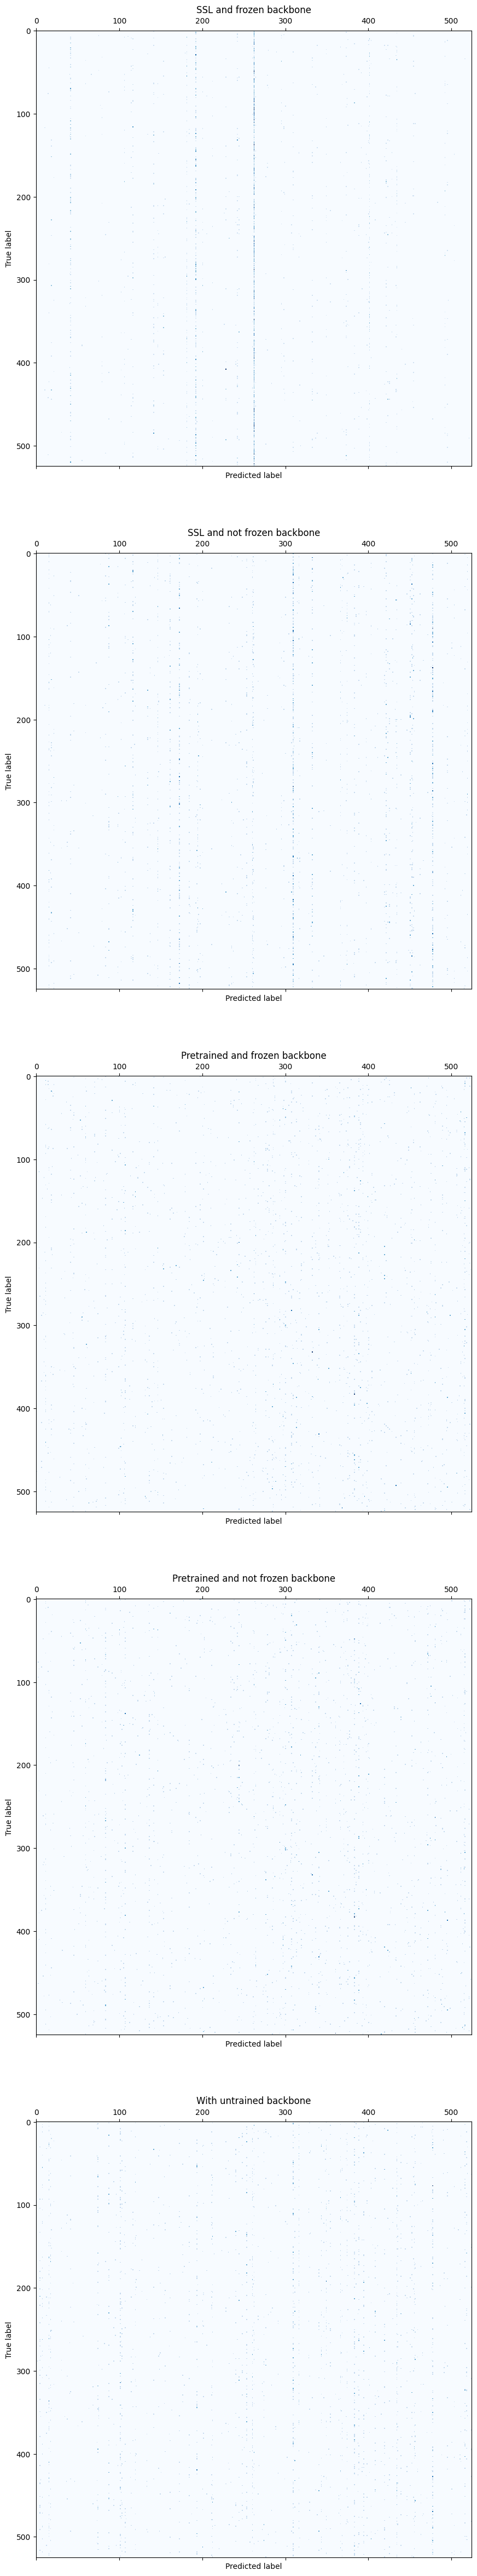

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(60, 60))
for i, ax in enumerate(axs):
    ax.matshow(confusion_matrices[i], cmap=plt.cm.Blues)
    ax.set_title(titles[i])
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.show()